---
title: Custom Widget
author: Colin Ophus
date: 2023/08/01
---

This is an example widget for more complicated interactive visualizations.

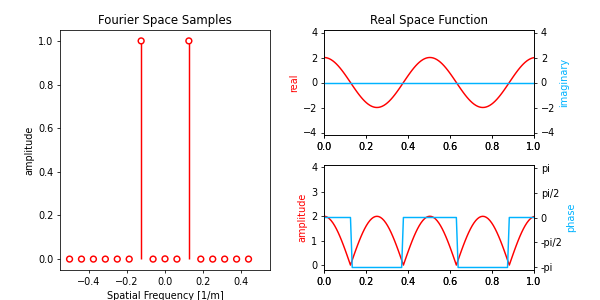

In [1]:
#| label: app:custom_fft
# Widget illustrating custom visualizations.

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
from ipywidgets import HBox, VBox, Dropdown, Layout, Label, Output, widgets
from matplotlib import cm

dpi = 72

class FourierTransform1D:
    """
    This class calculates and draws the 1D Fourier examples. Overall plot layout:
    left         -Fourier space, interactive scatter plot
    right top    -Real space, real/imag plotting, non-interative
    right bottom -Real space, real/imag plotting, non-interative
    
    Args:
        f (np.array):     numpy vector containing Fourier space representation of the function.
    
    """
    

    def __init__(
        self,
        f = np.zeros(32),
        ):
        
        # Figure layout
        self.fig = plt.figure(figsize=(600/dpi, 300/dpi), dpi=dpi)
        self.ax_FFT   = self.fig.add_axes([0.1,  0.1,  0.35, 0.8])
        self.ax_real  = self.fig.add_axes([0.54, 0.55, 0.35, 0.35])
        self.ax_imag  = self.fig.add_axes([0.54, 0.55, 0.35, 0.35])
        self.ax_abs   = self.fig.add_axes([0.54, 0.1,  0.35, 0.35])
        self.ax_phase = self.fig.add_axes([0.54, 0.1,  0.35, 0.35])

        # axes limits, labels
        self.ax_FFT.set_xlim([-0.55, 0.55])
        self.ax_FFT.set_ylim([-0.05,1.05])
        self.ax_FFT.set_xlabel('Spatial Frequency [1/m]')
        self.ax_FFT.set_title('Fourier Space Samples')
        self.ax_FFT.set_ylabel('amplitude')

        self.ax_real.set_xlim([0.0,1.0])
        self.ax_real.set_ylim([-4.2,4.2])
        self.ax_real.set_title('Real Space Function')
        self.ax_real.set_ylabel('real', color=(1,0,0,1))
        self.ax_real.patch.set_alpha(0.0)

        self.ax_imag.set_xlim([0.0,1.0])
        self.ax_imag.set_ylim([-4.2,4.2])
        self.ax_imag.yaxis.tick_right()
        self.ax_imag.yaxis.set_label_position('right')
        self.ax_imag.set_ylabel('imaginary', color=(0,0.7,1.0,1))
        self.ax_imag.patch.set_alpha(0.0)

        self.ax_abs.set_xlim([0.0,1])
        self.ax_abs.set_ylim([-0.2,4.1])
        self.ax_abs.set_ylabel('amplitude', color=(1,0,0,1))
        self.ax_abs.patch.set_alpha(0.0)

        self.ax_phase.set_xlim([0.0,1.0])
        self.ax_phase.set_ylim([-3.3,3.3])
        self.ax_phase.yaxis.tick_right()
        self.ax_phase.yaxis.set_label_position('right')
        self.ax_phase.set_ylabel('phase', color=(0,0.7,1.0,1))
        self.ax_phase.set_yticks((
            -np.pi,
            -np.pi/2,
            0.0,
            np.pi/2,
            np.pi,
        ))
        self.ax_phase.set_yticklabels((
            '-pi',
            '-pi/2',
            '0',
            'pi/2',
            'pi',
        ))
        self.ax_phase.patch.set_alpha(0.0)

        
        # Calculate plotting functions
        self.calc_inv_transform(f)
        
        # FFT plots
        mag = np.abs(self.f)
        phase = np.angle(self.f)
        phase_c = cm.hsv(np.mod(phase/(2*np.pi),1.0))
        self.p = self.ax_FFT.scatter(
            self.q,
            mag,
            marker='o',
            facecolors=(1,1,1,1), 
            edgecolors=phase_c,
            linewidth=1.5,
            zorder=4,
        )
        self.p_lines = self.ax_FFT.vlines(
            self.q,
            ymin=np.zeros_like(self.q),
            ymax=mag,
            color=phase_c,
            linewidth=1.5,
        )
        
        # real / imag plots
        self.p_real = self.ax_real.plot(
            self.r,
            self.f_real,
            color=(1,0,0,1), 
            linewidth=1.5,
        )
        self.p_imag = self.ax_imag.plot(
            self.r,
            self.f_imag,
            c=(0,0.7,1.0,1),
            linewidth=1.5,
        )
        
        # abs / phase plots
        self.p_abs = self.ax_abs.plot(
            self.r,
            self.f_abs,
            color=(1,0,0,1), 
            linewidth=1.5,
        )
        self.p_phase = self.ax_phase.plot(
            self.r,
            self.f_phase,
            c=(0,0.7,1.0,1),
            linewidth=1.5,
        )
        
    def calc_inv_transform(
        self,
        f,
        upsample_factor = 8,
        ):
        """
        This function calculates the inverse Fourier transform of a function, 
        zero-padding it to Fourier upsample the real space result. 
        It saves all values (including coordinate vectors for plotting) locally.
        """
        
        # Fourier space
        self.f = np.array(f,dtype='complex')
        self.q = np.fft.fftfreq(self.f.shape[0])
        
        # zero-padded Fourier space function
        self.f_pad = np.zeros((self.f.shape[0]-1)*upsample_factor, dtype='complex')
        self.f_pad[0:self.f.shape[0]//2] = self.f[0:self.f.shape[0]//2]
        self.f_pad[1-self.f.shape[0]//2:] = self.f[1-self.f.shape[0]//2:]
        # End point of padded Fourier space function
        self.f_pad[self.f.shape[0]//2] = self.f[self.f.shape[0]//2] * 0.5
        self.f_pad[-self.f.shape[0]//2] = np.conj(self.f[self.f.shape[0]//2]) * 0.5       
        
        # Real space
        self.r = np.linspace(0.0,1.0,self.f_pad.shape[0])
        f_rs = np.fft.ifft(self.f_pad) * self.f_pad.shape[0] 
        self.f_real  = np.real(f_rs)
        self.f_imag  = np.imag(f_rs)
        self.f_abs   = np.abs(f_rs)
        self.f_phase = np.angle(f_rs * np.exp(1j*1e-8))

    def update_plot(self,f):
        """
        Update the plots
        """
        # Calculate plotting functions
        self.calc_inv_transform(f)
        
        # FFT plots
        mag = np.abs(self.f)
        phase = np.angle(self.f)
        phase_c = cm.hsv(np.mod(phase/(2*np.pi),1.0))
        self.p.set_offsets(np.vstack((self.q,mag)).T)
        self.p.set_edgecolor(phase_c)

        seg_old = self.p_lines.get_segments()
        seg_new = [np.array([[qq,0],[qq,mm]]) for mm,qq in zip(mag,self.q)]
        self.p_lines.set_segments(seg_new)
        self.p_lines.set_color(phase_c)
        
        # real / imag
        self.p_real[0].set_xdata(self.r)
        self.p_real[0].set_ydata(self.f_real)
        self.p_imag[0].set_xdata(self.r)
        self.p_imag[0].set_ydata(self.f_imag)
        
        # amp / phase
        self.p_abs[0].set_xdata(self.r)
        self.p_abs[0].set_ydata(self.f_abs)
        self.p_phase[0].set_xdata(self.r)
        self.p_phase[0].set_ydata(self.f_phase)
        
        
# default function is a cosine wave
f = np.zeros(16, dtype='complex')
f[2] = 1.0 
f[0] = 0.001
f[-2] = 1.0
# fft = FourierTransform1D(f)

# # initialize plot
# out = Output(layout=Layout(width='400px',height='300px'))
out = Output()
# display(out)
with out:
    fft = FourierTransform1D(f);

# interactive movement of points - store variables inside fft
fft.point_ind = None
fft.qx_init = 0.0
fft.phase_init = 0.0
fft.dphase_dq = (2*np.pi) / 1.0

def button_press_callback(event):
    # mouse button pressed

    # if left click and within axes, proceed with mouse movement event
    if event.inaxes is None:
        return
    if event.button != 1:
        return
    
    # convert from screen coordinates to axis coordinates
    t = fft.ax_FFT.transData.inverted()
    qx_mag = t.transform([event.x,event.y])
    
    # determine closest point and initial phase of point
    fft.point_ind = np.argmin(np.abs(fft.q - qx_mag[0])).astype('int')
    fft.qx_init = qx_mag[0]
    fft.phase_init = np.angle(fft.f[fft.point_ind])

def motion_notify_callback(event):
    # during mouse movement
    if fft.point_ind is None:
        return
    if event.inaxes is None:
        return
    if event.button != 1:
        return
    
    # get point in axis coordinates
    t = fft.ax_FFT.transData.inverted()
    qx_mag = t.transform([event.x,event.y])
    
    # relative q value
    dq = qx_mag[0] - fft.qx_init
    phase_new = fft.phase_init + dq * fft.dphase_dq

    # update fft point
    fft.f[fft.point_ind] = np.maximum(qx_mag[1], 0.0) * np.exp(1j*phase_new)
    fft.update_plot(fft.f)


def button_release_callback(event):
    # mouse button released
    if event.button != 1:
        return
    fft.point_ind = None

# button callbacks
fft.fig.canvas.mpl_connect('button_press_event', button_press_callback)
fft.fig.canvas.mpl_connect('button_release_event', button_release_callback)
fft.fig.canvas.mpl_connect('motion_notify_event', motion_notify_callback)    
    
# Appearance
fft.fig.canvas.resizable=False
fft.fig.canvas.toolbar_visible = False
fft.fig.canvas.header_visible = False
fft.fig.canvas.footer_visible = False
fft.fig.canvas.layout.width = '600px'
    
# List of options
option_list = (
    'cosine wave', 
    'sine wave', 
    'plane wave', 
    'complex wavepacket',
    'complex tighter wavepacket',
    'real wavepacket - zero mean',
    'real wavepacket - positive',
    'atoms - 2',
    'atoms - 3',
    'atoms - 4',
)

# update the plots with a pre-selected function
def select_preset_eventhandler(change):
    f = np.zeros(16, dtype='complex')
    
    if change.new == option_list[0]:
        # cosine wave
        f[ 2] = 1.0 
        f[-2] = 1.0
    elif change.new == option_list[1]:
        # sine wave
        f[ 2] = -1j*1.0 
        f[-2] =  1j*1.0
    elif change.new == option_list[2]:
        # plane wave
        f[ 3] = 1j*1.0 
    elif change.new == option_list[3]:
        # complex wavepacket 
        f[ 5] = -1.0 
        f[ 6] =  1.0  
    elif change.new == option_list[4]:
        # complex tighter wavepacket 
        f[ 4] =  0.5
        f[ 5] = -1.0 
        f[ 6] =  1.0  
        f[ 7] = -0.5 
    elif change.new == option_list[5]:
        # wavepacket - zero mean
        f[ 7] =  0.5
        f[-8] = -1.0
        f[-7] =  0.5
    elif change.new == option_list[6]:
        # wavepacket - all positive values
        f[-7] = -0.25
        f[-8] =  0.5
        f[ 7] = -0.25
        f[-1] = -0.4
        f[ 0] =  1.0
        f[ 1] = -0.4
    elif change.new == option_list[7]:
        # atoms - 2
        f[-8] =  0.25
        f[-6] =  0.25
        f[-4] =  0.50
        f[-2] =  0.75
        f[ 0] =  1.01
        f[ 2] =  0.75
        f[ 4] =  0.50
        f[ 6] =  0.25
    elif change.new == option_list[8]:
        # atoms - 3
        f[-6] =  0.33
        f[-3] =  0.66
        f[ 0] =  1.01
        f[ 3] =  0.66
        f[ 6] =  0.33
    elif change.new == option_list[9]:
        # atoms - 4
        f[-8] =  0.5
        f[-4] =  0.5
        f[ 0] =  1.01
        f[ 4] =  0.5
        
    # apply update to plot
    fft.update_plot(f)

# Widgets
dropdown = Dropdown(
    options = option_list,
    layout = Layout(width='175px',height='30px'),
)
dropdown.observe(select_preset_eventhandler, names='value')

# widget layouts
widget = VBox([
    HBox([
        VBox([
            Label('Left click and drag Fourier space samples to change them.',
                  layout=Layout(width='400px',height='30px')),
            Label('up/down - change magnitude.  left/right - change phase.',
                  layout=Layout(width='400px',height='30px')),
        ]),
        
        VBox([
            Label('Preset Functions:',
                  layout=Layout(width='175px',height='30px')),
            dropdown
        ])
    ]),
    out,
]);

display(widget);      